# **Non-Stationary Federated Learning**



*   Deep Learning Framework: **PyTorch**
*   Dataset: **Synthetic**
*   Workers: **4**
*   Data Distribution: **IID on workers**





## Importing libraries and setting parameters for training


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import os
import numpy as np
import math

from Stationary.core import *
from Stationary.utils import *

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [2]:
num_workers = 4
num_rounds = 10

## Synthetic Dataset

We create a synthetic dataset, reproducing a linear correlation between inputs and outputs, with the addition of a noise.

Train set is divided into multiple slots, in order to reproduce the "online" approach: For each round, each worker has a different set for training phase.


In [6]:
# Linear Regression Coefficients
m = 1.4
c = 10

dataset_X = np.linspace(0, 10, 1000)
np.random.shuffle(dataset_X)

dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(3)

dataset_X = dataset_X.reshape(-1,1)
dataset_y = dataset_y.reshape(-1,1)

In [5]:
import pandas as pd

dirty_training_set = pd.read_csv('Datasets/train.csv')
dirty_test_set = pd.read_csv('Datasets/test.csv')


training_set = dirty_training_set.dropna() 
test_set = dirty_test_set.dropna() 

In [14]:
import pandas as pd

dataset = (pd.read_csv('Datasets/unconv_MV_v5.csv')).dropna()

In [15]:
dataset = dataset.drop(columns=['Well'])

In [16]:
dataset.head(10)

,Por,Perm,AI,Brittle,TOC,VR,Prod
0,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832
5,14.53,4.81,2.69,53.60,0.94,1.67,4395.763259
6,13.49,3.60,2.93,63.71,0.80,1.85,4104.400989
7,11.58,3.03,3.25,53.00,0.69,1.93,3496.742701
8,12.52,2.72,2.43,65.77,0.95,1.98,4025.851153
9,13.25,3.94,3.71,66.20,1.14,2.65,4285.026122


In [37]:
dataset_y = dataset['Prod'].to_numpy().reshape(-1,1)

In [38]:
dataset_X = dataset.drop(columns = ['Prod']).to_numpy()

In [34]:
train_X = training_set.to_numpy().transpose()[0].reshape(-1,1)
train_y = training_set.to_numpy().transpose()[1].reshape(-1,1)

test_X = test_set.to_numpy().transpose()[0].reshape(-1,1)
test_y = test_set.to_numpy().transpose()[1].reshape(-1,1)

In [39]:
train_percentage = 0.9


train_X, test_X = np.split(dataset_X, 
            [int(train_percentage * len(dataset_X))
            ])

train_y, test_y = np.split(dataset_y, 
            [int(train_percentage * len(dataset_y))
            ])

In [40]:
train_list_X = splitDataset(train_X, num_workers, num_rounds)
train_list_y = splitDataset(train_y, num_workers, num_rounds)

In [41]:
worker_list = []
for i in range(0, num_workers):
    worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

In [42]:
server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)

In [43]:
from collections import defaultdict

# stores losses trend for each worker along epochs
worker_losses_dict = defaultdict(list)


error = []
score = []



for i in range(0, num_rounds):
    
    for j in range(0, num_workers):
        
        worker_list[j].train(X = train_list_X[i*num_workers+j] , y = train_list_y[i*num_workers+j])
        pred_worker = worker_list[j].evaluate(test_X)
        
        # store loss info for current epoch 
        worker_losses_dict[j].append(mean_squared_error(test_y, pred_worker))
    
    server.aggregation() 
    server.return_to_workers()
    
    pred_server = server.evaluate(test_X)
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error.append(mean_squared_error(test_y, pred_server))
    score.append(r2_score(test_y, pred_server))

------ROUND 1------
Mean squared error: 117125.675
Coefficient of determinaton: 0.897 

------ROUND 2------
Mean squared error: 83864.862
Coefficient of determinaton: 0.926 

------ROUND 3------
Mean squared error: 71150.204
Coefficient of determinaton: 0.937 

------ROUND 4------
Mean squared error: 117454.614
Coefficient of determinaton: 0.896 

------ROUND 5------
Mean squared error: 96896.831
Coefficient of determinaton: 0.915 

------ROUND 6------
Mean squared error: 108639.941
Coefficient of determinaton: 0.904 

------ROUND 7------
Mean squared error: 106921.908
Coefficient of determinaton: 0.906 

------ROUND 8------
Mean squared error: 86226.635
Coefficient of determinaton: 0.924 

------ROUND 9------
Mean squared error: 77174.385
Coefficient of determinaton: 0.932 

------ROUND 10------
Mean squared error: 75190.078
Coefficient of determinaton: 0.934 



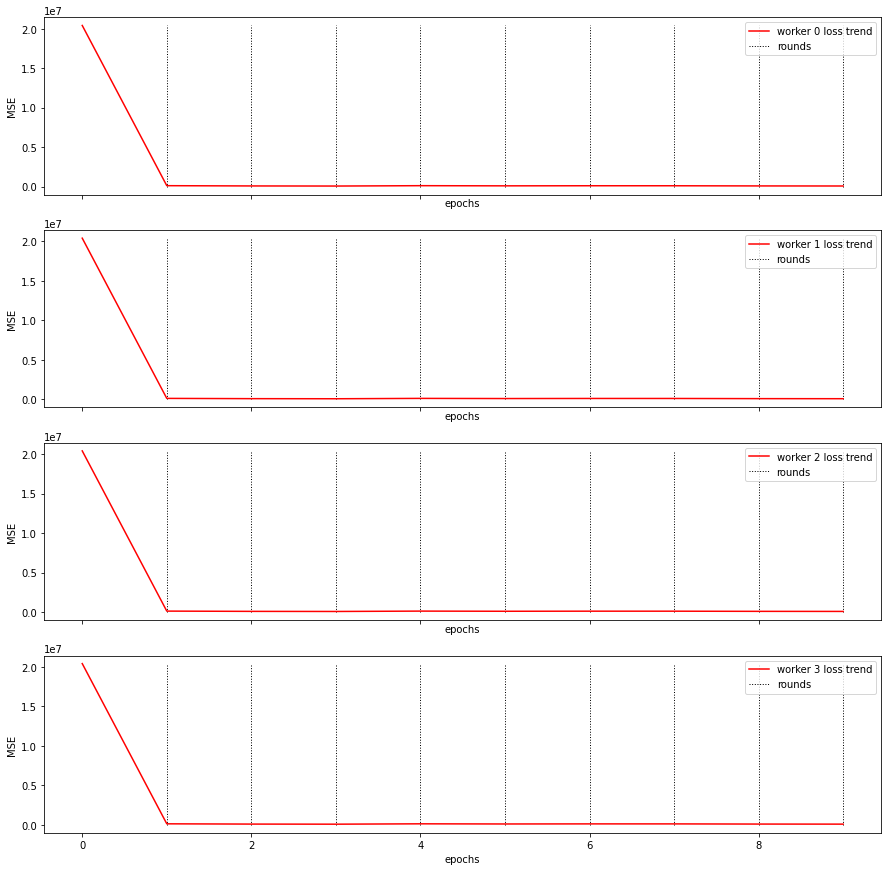

In [44]:
# plot loss over epochs for each worker

fig, axs = plt.subplots(num_workers, 1, sharex=True, figsize=(15, 15))
for k, v in worker_losses_dict.items():
    axs[k].plot(v, label = "worker {} loss trend".format(k), color = 'red')
    axs[k].set_xlabel("epochs")
    axs[k].set_ylabel("MSE")
    
    axs[k].vlines((np.arange(num_rounds))[1:], ymin = 0, ymax = np.max(v), linewidth=1, linestyle=':', label = 'rounds')
    
    axs[k].legend()


plt.savefig("loss_trend_linearRegression.pdf", bbox_inches='tight')

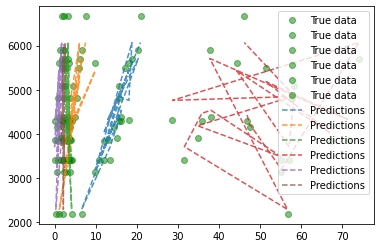

In [45]:
plt.clf()
plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, pred_server, '--', label='Predictions', alpha=0.8)
plt.legend(loc='best')
plt.show()

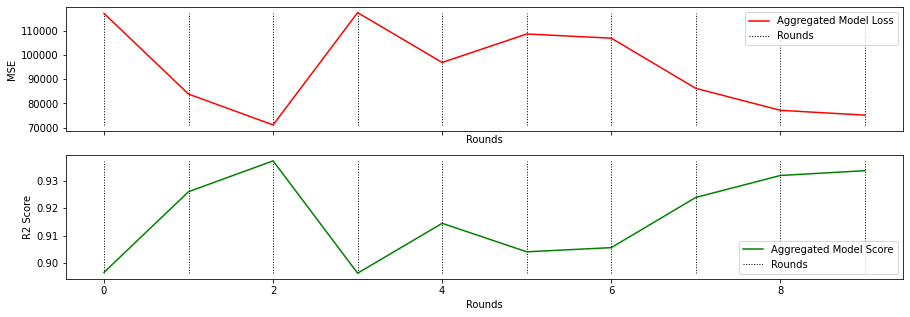

In [46]:
e = np.asarray(error)
a = np.asarray(score)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

axs[0].plot(e, label = "Aggregated Model Loss", color = 'red')
axs[0].set_xlabel("Rounds")
axs[0].set_ylabel("MSE")
axs[0].vlines((np.arange(num_rounds))[0:], ymin = np.min(e), ymax = np.max(e), linewidth=1, linestyle=':', label = 'Rounds')
axs[0].legend()

axs[1].plot(a, label = "Aggregated Model Score", color = 'green')
axs[1].set_xlabel("Rounds")
axs[1].set_ylabel("R2 Score")
axs[1].vlines((np.arange(num_rounds))[0:], ymin = np.min(a), ymax = np.max(a), linewidth=1, linestyle=':', label = 'Rounds')
axs[1].legend()

plt.savefig("Score_trend_LinearRegression.pdf", bbox_inches='tight')

# Federated Averaging

Implementation of FedAVG in PyTorch. 

First of all, the dataset is converted in tensors.
Then, a model, a loss function and an optimizer are instantiated for each worker.
Model parameters are averaged at each round.

In [47]:
from torch.autograd import Variable

for i in range(0, len(train_list_X)):
    train_list_X[i] = torch.from_numpy(train_list_X[i])

for i in range(0, len(train_list_y)):
    train_list_y[i] = torch.from_numpy(train_list_y[i])

## Model


In [48]:
import torch.nn.functional as F

class customModel(torch.nn.Module):
    
    def __init__(self, inputSize, outputSize, H = 10):
        
        super(customModel, self).__init__()
        self.linear = torch.nn.Linear(inputSize, H, bias=True)
        self.linear2 = torch.nn.Linear(H, outputSize)

        
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.linear2(x)
        return x


In [49]:
w = []

for i in range(0, num_workers):
    
    w.append(customModel(dataset_X[0].size, dataset_y[0].size))
    w[i] = w[i].float()

In [50]:
learning_rate = 1e-3

criterion = []
optimizers = []

for i in w:
    
    criterion.append(torch.nn.MSELoss()) 
    optimizers.append(torch.optim.Adam(i.parameters(), lr=learning_rate))

In [51]:
params = []


for i in w:
    params.append(list(i.parameters()))

In [52]:
from collections import defaultdict

local_epochs = 1000

error = []
score = []


for model in w:
    model.train()
    

# stores losses trend for each worker along epochs
worker_losses_dict = defaultdict(list)


for i in range(num_rounds):
    
    print("\n## ## ## ROUND {} ## ## ##\n".format(i))
    
    for j in range(0, num_workers):
        
        #print("# # # WORKER {} # # #\n".format(j))

        for epoch in range(local_epochs):
            
            optimizers[j].zero_grad()
            loss = 0
            
            for x in range(len(train_list_X[i*num_workers+j])):
                inputs = (train_list_X[i*num_workers+j][x]).float()
                inputs = inputs.unsqueeze(0)
                labels = (train_list_y[i*num_workers+j][x]).float()
                labels = labels.unsqueeze(0)
                y_pred = w[j](inputs)
                loss += criterion[j](y_pred, labels)
            
            # store loss info for current epoch 
            worker_losses_dict[j].append(loss)
            
            loss.backward()
            optimizers[j].step()
        
        #print("loss:\t{}".format(loss))    
        """
        predicted = w[j](Variable(torch.from_numpy(test_X).float())).data.numpy()
        
        print('Mean squared error: %.3f\n' 
              % mean_squared_error(test_y, predicted))
        print('Coefficient of determinaton: %.3f \n\n'
              % r2_score(test_y, predicted))
        error.append(mean_squared_error(test_y, predicted))
        score.append(r2_score(test_y, predicted))
        """
    
    new_params = list()

    for param_i in range(len(params[0])):

        spdz_params = list()

        for remote_index in range(len(w)):
            spdz_params.append(params[remote_index][param_i])
        
        spdz = torch.tensor([0.0]).float()

        for k in spdz_params:
            spdz = spdz + k
        
        new_param = (spdz) / len(w)
        new_params.append(new_param)
    
    with torch.no_grad():
        for model in params:
            for param in model:
                param *= 0
        
        for remote_index in range(len(w)):
            for param_index in range(len(params[remote_index])):
                #params[remote_index][param_index].set_(new_params[param_index])
                params[remote_index][param_index] = torch.nn.Parameter(new_params[param_index])
    
    predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()
    
    print('------ROUND {}------'.format(i))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, predicted))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, predicted))
    error.append(mean_squared_error(test_y, predicted))
    score.append(r2_score(test_y, predicted))
    


## ## ## ROUND 0 ## ## ##

------ROUND 0------
Mean squared error: 20420680.152
Coefficient of determinaton: -17.016 


## ## ## ROUND 1 ## ## ##

------ROUND 1------
Mean squared error: 20406669.276
Coefficient of determinaton: -17.004 


## ## ## ROUND 2 ## ## ##

------ROUND 2------
Mean squared error: 20180590.157
Coefficient of determinaton: -16.804 


## ## ## ROUND 3 ## ## ##

------ROUND 3------
Mean squared error: 11632437.146
Coefficient of determinaton: -9.263 


## ## ## ROUND 4 ## ## ##

------ROUND 4------
Mean squared error: 4429715.697
Coefficient of determinaton: -2.908 


## ## ## ROUND 5 ## ## ##

------ROUND 5------
Mean squared error: 1647839.929
Coefficient of determinaton: -0.454 


## ## ## ROUND 6 ## ## ##

------ROUND 6------
Mean squared error: 1137391.351
Coefficient of determinaton: -0.003 


## ## ## ROUND 7 ## ## ##

------ROUND 7------
Mean squared error: 2877663.285
Coefficient of determinaton: -1.539 


## ## ## ROUND 8 ## ## ##

------ROUND 8------
M

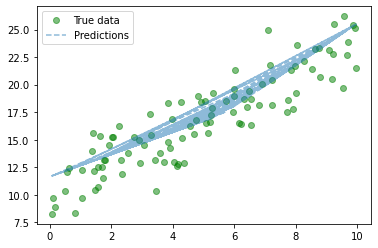

In [24]:
with torch.no_grad(): 
    predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()

plt.clf()
plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, predicted,'--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

In [19]:
print(mean_squared_error(test_y, predicted))
print(r2_score(test_y, predicted))

4.033371600375843
0.777331840110735


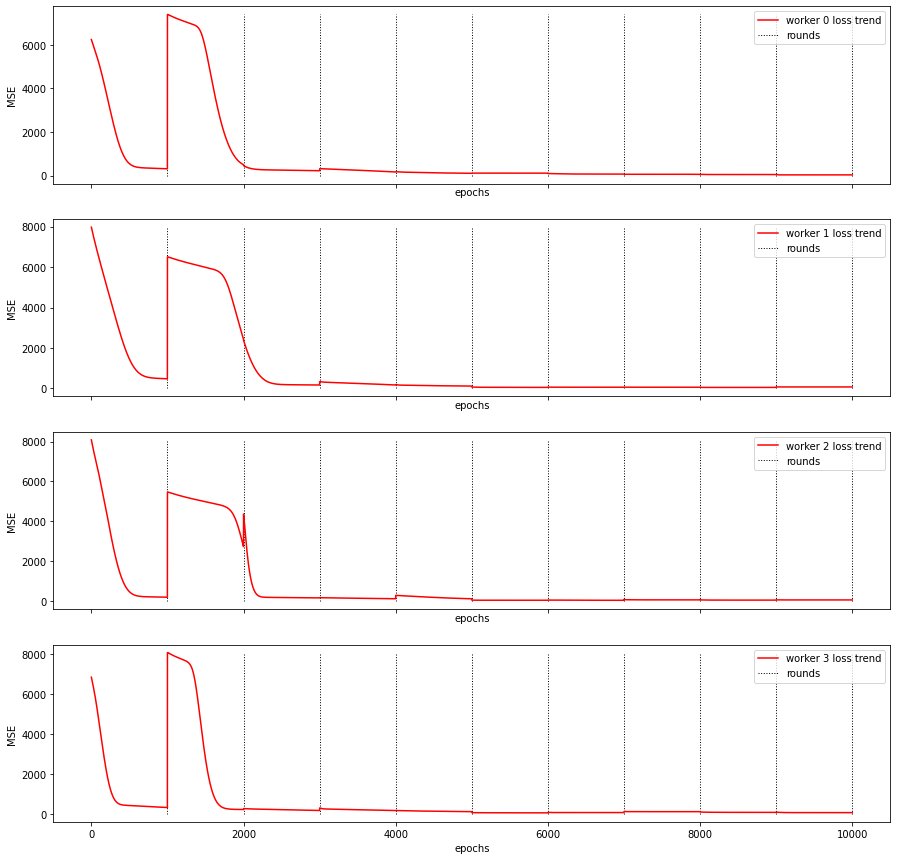

In [20]:
# plot loss over epochs for each worker

fig, axs = plt.subplots(num_workers, 1, sharex=True, figsize=(15, 15))
for k, v in worker_losses_dict.items():
    axs[k].plot(v, label = "worker {} loss trend".format(k), color = 'red')
    axs[k].set_xlabel("epochs")
    axs[k].set_ylabel("MSE")
    
    axs[k].vlines((np.arange(num_rounds+1)*local_epochs)[1:], ymin = 0, ymax = np.max(v), linewidth=1, linestyle=':', label = 'rounds')
    
    axs[k].legend()


plt.savefig("loss_trend.pdf", bbox_inches='tight')